## Machine Learning Project: Customer Churn Predictions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Loading and displaying data from Telco Customer Churn (https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

In [2]:
data_file = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(data_file.head())

# Check column names and data types
print(data_file.info())

# Summary statistics
print(data_file.describe())

# Check for missing values
print(data_file.isnull().sum())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

### PREPROCESSING
Convert categorical columns into numbers using LabelEncoder and OneHotEncoder

In [3]:
x = pd.get_dummies(data_file, columns=["InternetService", "Contract", "PaymentMethod","MultipleLines"], drop_first=True)
y = data_file["Churn"]  # 'Churn' column is the target variable (y)
#gender = pd.get_dummies(data_file['gender'], drop_first=True)  # Convert categorical columns into numbers
encoder = LabelEncoder()
one_enc = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
y=encoder.fit_transform(y)
categorical_columns = ["gender", "Partner", "Dependents", "PhoneService","OnlineSecurity","DeviceProtection",
                       "TechSupport","StreamingTV","StreamingMovies","PaperlessBilling",
                       "OnlineBackup","InternetService_Fiber optic", "InternetService_No",
                       "Contract_One year", "Contract_Two year","PaymentMethod_Credit card (automatic)",
                       "PaymentMethod_Electronic check", "PaymentMethod_Mailed check",
                       "MultipleLines_No phone service","MultipleLines_Yes"]  # Add all categorical column names here

for col in categorical_columns:
    x[col] = one_enc.fit_transform(x[[col]])  # Encode all categorical columns

x["TotalCharges"] = pd.to_numeric(x["TotalCharges"], errors="coerce")

x["TotalCharges"].fillna(0, inplace=True)
x = x.drop("Churn", axis=1)  # Drop the 'Churn' column from features (X)
x = x.drop("customerID", axis=1)  # Drop the 'Churn' column from features (X)

/tmp/ipykernel_368/1939008193.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x["TotalCharges"].fillna(0, inplace=True)


### MODEL AND GRIDSEARCH 
Implement the Logistic Regression model adapting the maximum iterations depinding on the computing capacity. Gridsearch is used to test how different parameters, in this cases class weight, impact the precision, accuracy and recall score of the model.

We fit over the recall score as in this case we prefer minimizing false negatives than false positives.

In [19]:
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
#pipe = Pipeline([
#    ("scale",StandardScaler()),
#    ("model",LogisticRegression(max_iter=1000))])
#pipe.fit(X_train, y_train)

# Train the model

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=10000),
    param_grid={'class_weight':[{0:1,1:n} for n in np.linspace(1,20,20)]},
    scoring={'precision':make_scorer(precision_score),'recall_score':make_scorer(recall_score),
             'accuracy':make_scorer(accuracy_score)},
    refit='recall_score',
    return_train_score=True,
    cv=10,
    n_jobs=-1)
grid.fit(x, y)

# Make predictions
y_pred = grid.predict(x)

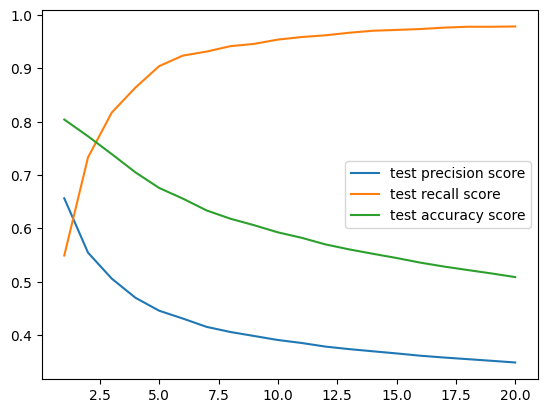

In [20]:
data=pd.DataFrame(grid.cv_results_)
arr = np.linspace(1,20,20)
plt.plot(arr,data['mean_test_precision'],label='test precision score')
plt.plot(arr,data['mean_test_recall_score'],label='test recall score')
plt.plot(arr,data['mean_test_accuracy'],label='test accuracy score')

plt.legend()
plt.show()


## IMPLEMENTING A NEW MODEL

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [35]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

grid_2 = GridSearchCV(
    estimator=model,
    param_grid={'max_depth': [5,10, 20],  # Deeper trees may improve recall
        'min_samples_split': [2, 5, 15],
        'class_weight':[{0:1,1:n} for n in np.linspace(1,20,20)]},
    scoring={'precision':make_scorer(precision_score),'recall_score':make_scorer(recall_score),
             'accuracy':make_scorer(accuracy_score),'roc_auc_score':make_scorer(roc_auc_score)},
    refit='recall_score',
    return_train_score=True,
    cv=10,
    n_jobs=-1)
grid_2.fit(x, y)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: np.float64(1.0)},
                                          {0: 1, 1: np.float64(2.0)},
                                          {0: 1, 1: np.float64(3.0)},
                                          {0: 1, 1: np.float64(4.0)},
                                          {0: 1, 1: np.float64(5.0)},
                                          {0: 1, 1: np.float64(6.0)},
                                          {0: 1, 1: np.float64(7.0)},
                                          {0: 1, 1: np.float64(8.0)},
                                          {0: 1, 1: np.float64(9.0)},
                                          {0: 1, 1: np.float64(10.0)},
                                          {0...
                         'min_samples_split': [2, 5, 15]},
             refit='recall_score', return_train_score=True,
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall_score': make_scorer(recall_score, response_method='predict'),
                      'roc_auc_score': make_scorer(roc_auc_score, response_method='predict')})

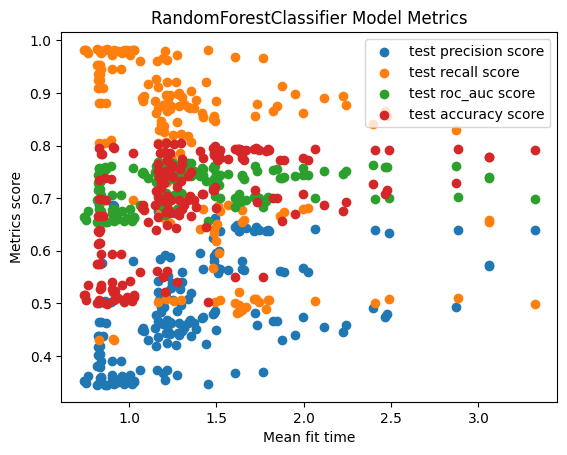

In [36]:
data_2=pd.DataFrame(grid_2.cv_results_)
arr = np.linspace(1,20,20)
plt.scatter(data_2['mean_fit_time'],data_2['mean_test_precision'],label='test precision score')
plt.scatter(data_2['mean_fit_time'],data_2['mean_test_recall_score'],label='test recall score')
plt.scatter(data_2['mean_fit_time'],data_2['mean_test_roc_auc_score'],label='test roc_auc score')
plt.scatter(data_2['mean_fit_time'],data_2['mean_test_accuracy'],label='test accuracy score')
plt.ylabel('Metrics score')
plt.xlabel('Mean fit time')
plt.title('RandomForestClassifier Model Metrics')
plt.legend()
plt.show()


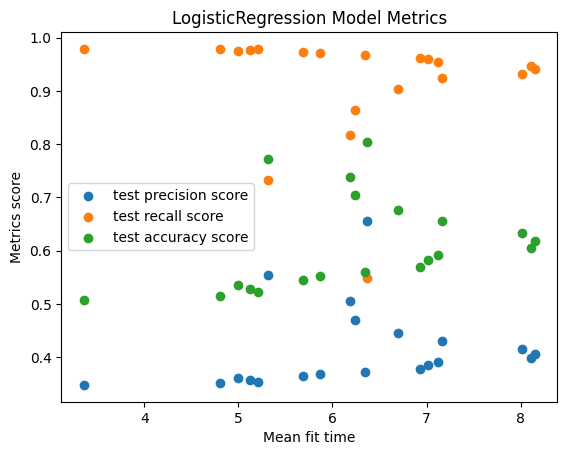

In [34]:
plt.scatter(data['mean_fit_time'],data['mean_test_precision'],label='test precision score')
plt.scatter(data['mean_fit_time'],data['mean_test_recall_score'],label='test recall score')
plt.scatter(data['mean_fit_time'],data['mean_test_accuracy'],label='test accuracy score')
plt.ylabel('Metrics score')
plt.xlabel('Mean fit time')
plt.title('LogisticRegression Model Metrics')
plt.legend()
plt.show()


RandomForestClassifier performs better if we solely focus on the recall score (minimize the false positives) with a lower mean fit time.